In [42]:
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import math
import matplotlib.pyplot as plt
import torch
import urllib
import numpy as np
import PIL

In [43]:
device = torch.device("cuda:0")

In [44]:
def get_sample_image()-> PIL.Image.Image:
    """
    Function for getting the image

    Output: image (from PIL library)
    """
    url = 'https://th.bing.com/th/id/OIG.djagjavuxNoM57xrLlKD?pid=ImgGn'
    filename = 'cat.jpg'
    urllib.request.urlretrieve(url, filename)
    return PIL.Image.open(filename)

In [45]:
def plot_noise_distribution(noise, predicted_noise):
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()
    

In [46]:
def plot_noise_prediction(noise, predicted_noise):
    plt.figure(figsize=(15,15))
    f, ax = plt.subplots(1, 2, figsize = (5,5))
    ax[0].imshow(reverse_transform(noise))
    ax[0].set_title(f"ground truth noise", fontsize = 10)
    ax[1].imshow(reverse_transform(predicted_noise))
    ax[1].set_title(f"predicted noise", fontsize = 10)
    plt.show()

In [47]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        """
        Constructor:

        Number start_schedule -> beta_0
        Number end_schedule -> beta_T
        Number timesteps -> t
        List<Number> betas -> amounts of noise that are being applied at every timestep of the diffusion process
        List<Number> alphas -> how much of the real image is left
        List<Number> alphas_cumprod -> alpha hat (t) is cumulative product of alphas all the way to t
        """
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps
        
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        
    def forward(self, x_0, t, device):
        """
        Function for the forward diffusion.
        Input:
              <Image> x_0 -> initial image,
              List<Number> t -> time steps
        Output:
              List<Image> mean + variance -> set of images for each time step,
              List<Tensor> noise -> set of noise matrixes for each time step
        """
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)
            
        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
        
        return mean + variance, noise.to(device)
    
    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        """
        The model predicts the noise in the image[t],
        then returns the image[t-1] with less noise.
        Input:
              Image x -> image at time t
              Number t -> time step we are currently in
              UnetModel model -> Trainned Unet model
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise 
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        """
        get values[t]
        Input:
              List<-> values -> list of values
              List<Number> t -> positions t you wish to get
        Output:
              - result -> reshaped element values[t]
        """
        result = values.gather(-1, t.cpu())
        """
        if
        x_shape = (5, 3, 64, 64)
            -> len(x_shape) = 4
            -> len(x_shape) -1 = 3

        and so, we reshape 'out' to dims
        (batch_size, 1, 1, 1)
        """
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)
        
        

In [48]:
IMAGE_SHAPE = (32, 32) #Image rescaled to 32x32 to reduce computational burden

In [49]:


transform = transforms.Compose([# PIL -> Torch
    transforms.Resize(IMAGE_SHAPE), # Resize the input image
    transforms.ToTensor(), # Convert to torch tensor (scales data into [0,1])
    transforms.Lambda(lambda t: (t * 2) - 1), #now maps from -1 to 1
    # dims now go: (bsize, channels, height-width)
])


reverse_transform = transforms.Compose([# Torch -> PIL,
    transforms.Lambda(lambda t: (t + 1) / 2), #go back to 0 to 1 mapping
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # We change so dims go like (bsize, height-width, channels)
    transforms.Lambda(lambda t: t * 255.), # 255 color range
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)), # Convert into uint8 numpy array
    transforms.ToPILImage(), # Convert back to PIL image
])

In [50]:
pil_image = get_sample_image()
torch_image = transform(pil_image)

In [51]:
diffusion_model = DiffusionModel()

<Figure size 6400x6400 with 0 Axes>

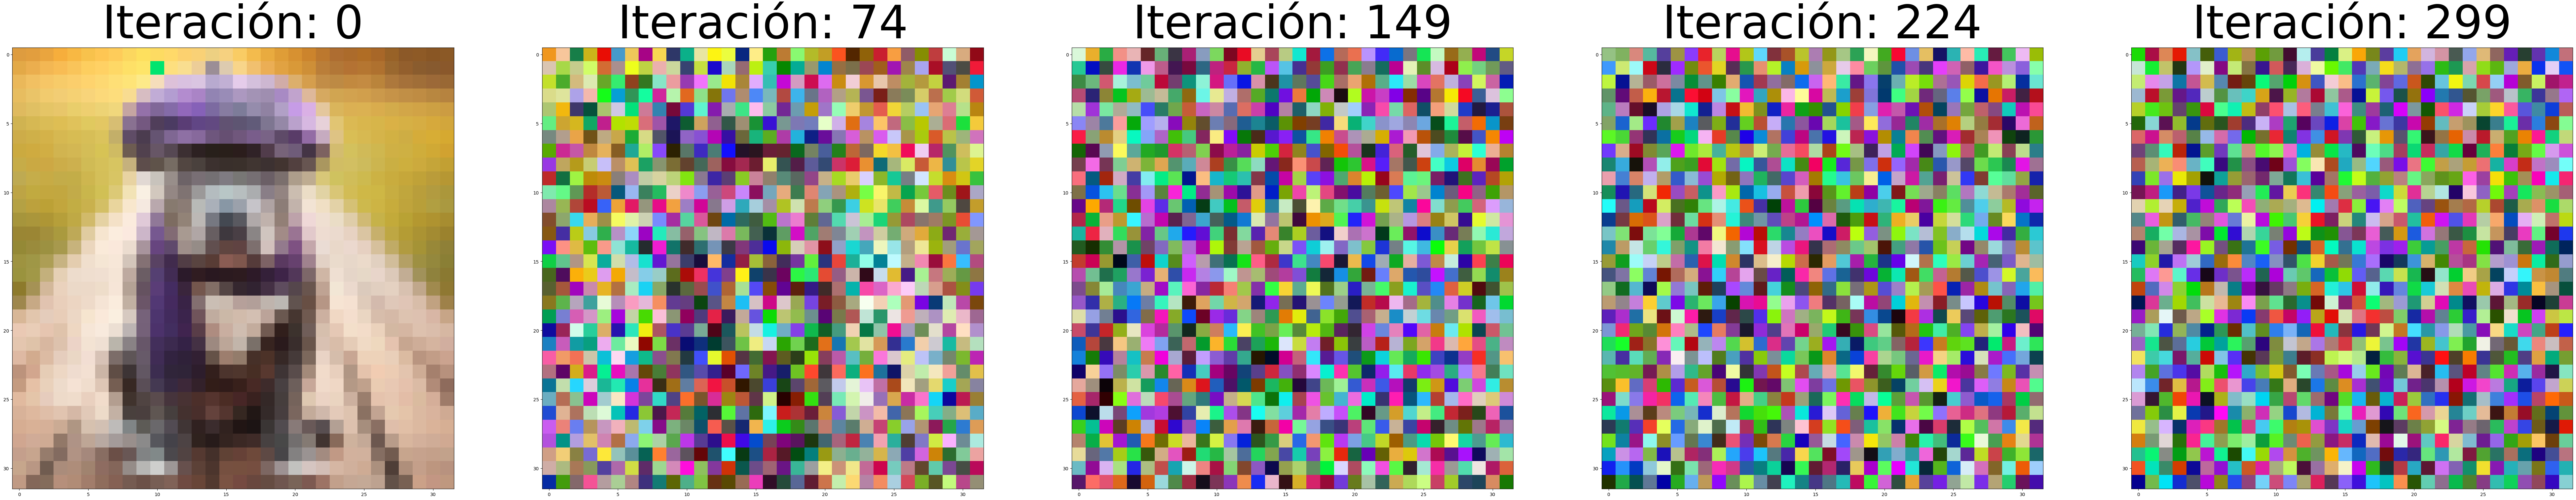

In [52]:
# To display some images of the forward diffusion
NO_DISPLAY_IMAGES = 5
torch_image_batch = torch.stack([torch_image] * NO_DISPLAY_IMAGES)
t = torch.linspace(0, diffusion_model.timesteps - 1, NO_DISPLAY_IMAGES).long()
noisy_image_batch, _ = diffusion_model.forward(torch_image_batch, t, device)

plt.figure(figsize=(64,64))
f, ax = plt.subplots(1, NO_DISPLAY_IMAGES, figsize = (100,100))

for idx, image in enumerate(noisy_image_batch):
    ax[idx].imshow(reverse_transform(image))
    ax[idx].set_title(f"Iteración: {t[idx].item()}", fontsize = 100)
plt.show()
    

In [55]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [56]:
class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters = 3, downsample=True):
        super().__init__()
        
        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        self.labels = labels
        if labels:
            self.label_mlp = nn.Linear(1, channels_out)
        
        self.downsample = downsample
        
        if downsample:
            self.conv1 = nn.Conv2d(channels_in, channels_out, num_filters, padding=1)
            self.final = nn.Conv2d(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(2 * channels_in, channels_out, num_filters, padding=1)
            self.final = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1)
            
        self.bnorm1 = nn.BatchNorm2d(channels_out)
        self.bnorm2 = nn.BatchNorm2d(channels_out)
        
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1)
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):
        o = self.bnorm1(self.relu(self.conv1(x)))
        o_time = self.relu(self.time_mlp(self.time_embedding(t)))
        o = o + o_time[(..., ) + (None, ) * 2]
        if self.labels:
            label = kwargs.get('labels')
            o_label = self.relu(self.label_mlp(label))
            o = o + o_label[(..., ) + (None, ) * 2]
            
        o = self.bnorm2(self.relu(self.conv2(o)))

        return self.final(o)

In [57]:
class UNet(nn.Module):
    def __init__(self, img_channels = 3, time_embedding_dims = 128, labels = False, sequence_channels = (64, 128, 256, 512, 1024)):
        super().__init__()
        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)
        
        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1)

    
    def forward(self, x, t, **kwargs):
        residuals = []
        o = self.conv1(x)
        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)
            
        return self.conv2(o)

In [58]:
NO_EPOCHS = 1500 # Number of Epochs
PRINT_FREQUENCY = 250 # After how many epochs we want to see model's progress
LR = 0.001 # Learning rate
BATCH_SIZE = 128
VERBOSE = True

unet = UNet(labels=False)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

---
Epoch: 0 | Train Loss 1.034072995185852


<Figure size 1500x1500 with 0 Axes>

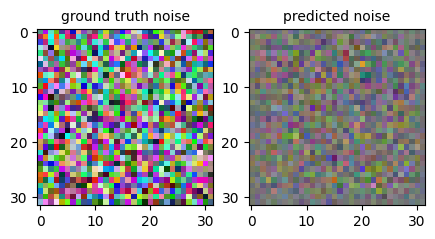

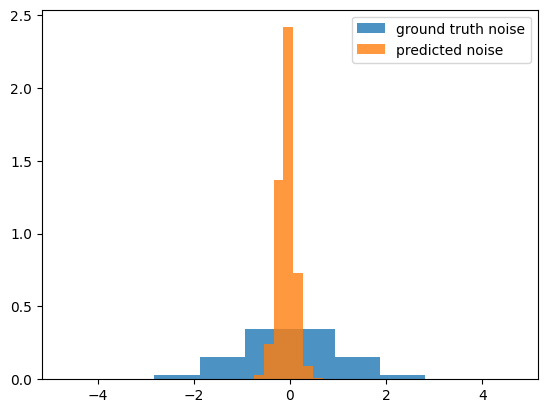

---
Epoch: 250 | Train Loss 0.03284080699086189


<Figure size 1500x1500 with 0 Axes>

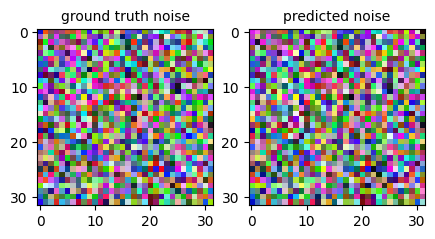

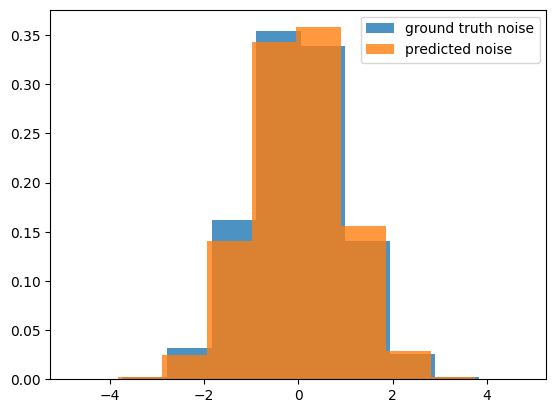

---
Epoch: 500 | Train Loss 0.013920621946454048


<Figure size 1500x1500 with 0 Axes>

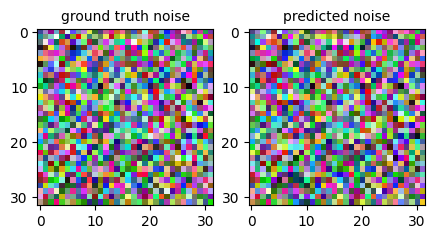

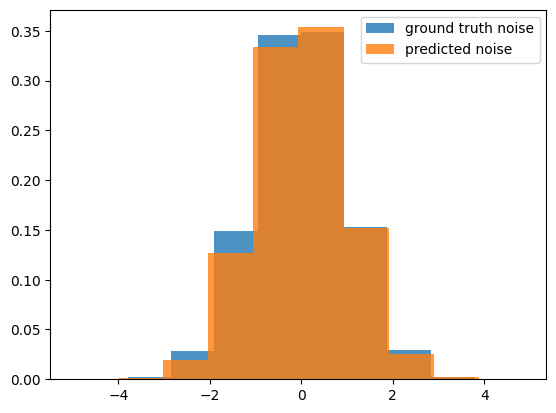

---
Epoch: 750 | Train Loss 0.02229417860507965


<Figure size 1500x1500 with 0 Axes>

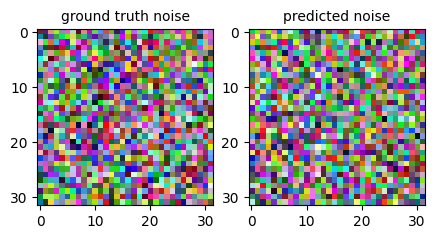

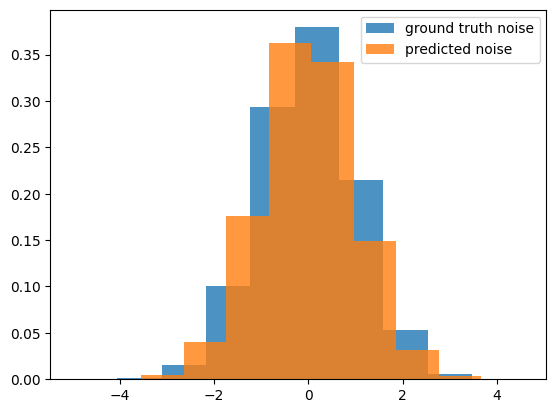

---
Epoch: 1000 | Train Loss 0.009721050970256329


<Figure size 1500x1500 with 0 Axes>

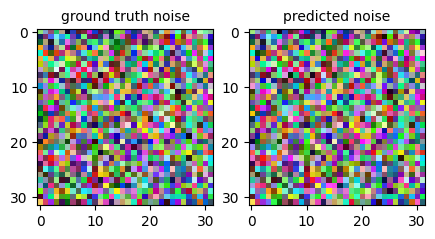

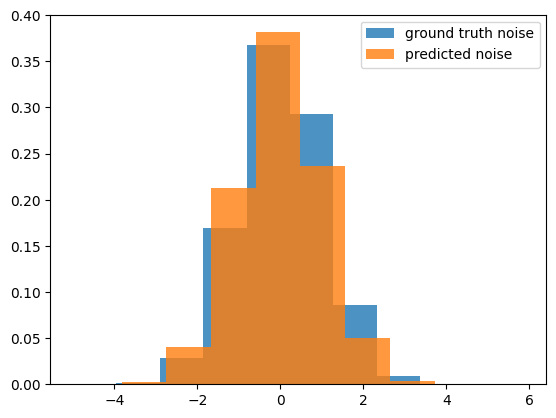

---
Epoch: 1250 | Train Loss 0.017836501821875572


<Figure size 1500x1500 with 0 Axes>

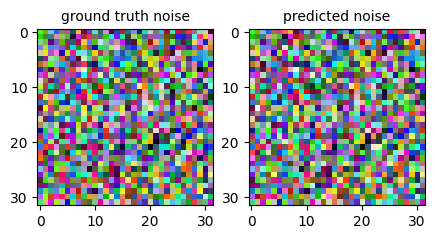

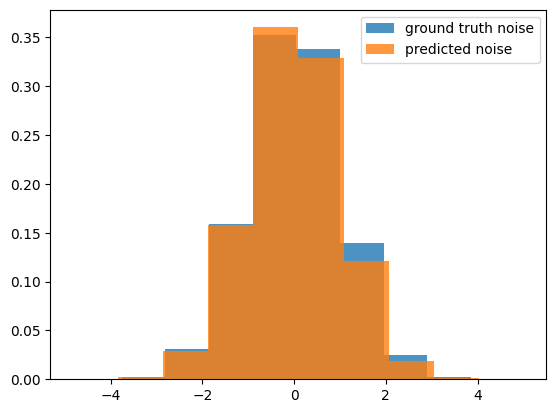

In [59]:
for epoch in range(NO_EPOCHS):
    """
    List<image> x0 ->input batch
    t -> sampled uniformly from the number of possible diffusion steps

    then we do argmin W (noise - gt_noise)

    Finally, in the if, we print predicted noise vs ground truth noise.

    """
    mean_epoch_loss = [] # To track the mse loss per epoch
    
    batch = torch.stack([torch_image] * BATCH_SIZE) # Creation of batch of images
    t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device) # Sample some random t's

    batch_noisy, noise = diffusion_model.forward(batch, t, device)  # Forward diffusion to time t
    predicted_noise = unet(batch_noisy, t) # Predicted noise of the image, given it is in time t
    
    optimizer.zero_grad() # Sets gradients of all model parameters to zero.
    loss = torch.nn.functional.mse_loss(noise, predicted_noise) # Loss function is diffrerence between real noise and predicted noise
    mean_epoch_loss.append(loss.item()) # Append loss of current epoch

    loss.backward() # Backward propagation of the gradient
    optimizer.step() # Take the step
    
    #Finally print gt_noise vs predicted_noise graphs
    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_prediction(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)

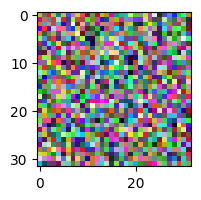

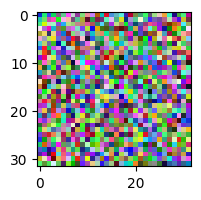

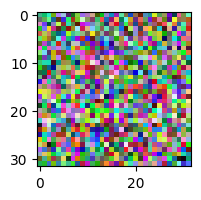

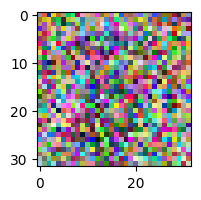

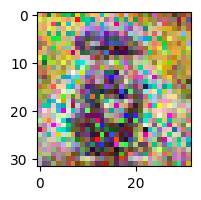

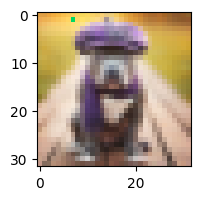

In [60]:
#FOR THE SAMPLING IMPLEMENTATION
with torch.no_grad():
    img = torch.randn((1, 3) + IMAGE_SHAPE).to(device) # Initialization of pure noise image, time T (x_T)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device) # Tensor t
        img = diffusion_model.backward(img, t, unet.eval()) # Image at time step t
        if i % 50 == 0:
            plt.figure(figsize=(2,2))
            plt.imshow(reverse_transform(img[0]))
            plt.show()
            

In [19]:
BATCH_SIZE = 256
NO_EPOCHS = 100
PRINT_FREQUENCY = 1
LR = 0.001
VERBOSE = False

unet = UNet(labels=True)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

In [20]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []
    mean_epoch_loss_val = []
    #Trainning
    for batch, label in trainloader:
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)
        batch_noisy, noise = diffusion_model.forward(batch, t, device) 
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))

        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
        mean_epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    #testing?
    for batch, label in testloader:

        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)

        batch_noisy, noise = diffusion_model.forward(batch, t, device) 
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))

        loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
        mean_epoch_loss_val.append(loss.item())

    #Epoch info
    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_prediction(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)
                
        torch.save(unet.state_dict(), f"epoch: {epoch}")

---
Epoch: 0 | Train Loss 0.18005336419894144 | Val Loss 0.08954189641353412
---
Epoch: 1 | Train Loss 0.08392741806232012 | Val Loss 0.07945376691909936
---
Epoch: 2 | Train Loss 0.07836511465601433 | Val Loss 0.07866410509898113
---
Epoch: 3 | Train Loss 0.0769740091302456 | Val Loss 0.07682688190386845
---
Epoch: 4 | Train Loss 0.07461077517423874 | Val Loss 0.0745908295114835
---
Epoch: 5 | Train Loss 0.07436560900547566 | Val Loss 0.07398852457602818
---
Epoch: 6 | Train Loss 0.07299822603280727 | Val Loss 0.0719890947907399
---
Epoch: 7 | Train Loss 0.07298718648843276 | Val Loss 0.07119846812043434
---
Epoch: 8 | Train Loss 0.07234191607970458 | Val Loss 0.07274757631314106
---
Epoch: 9 | Train Loss 0.07121543710430463 | Val Loss 0.07040634837288123
---
Epoch: 10 | Train Loss 0.07018767622036812 | Val Loss 0.07037404571206142
---
Epoch: 11 | Train Loss 0.06941806389353214 | Val Loss 0.07113508297464786
---
Epoch: 12 | Train Loss 0.07023696299546804 | Val Loss 0.06870854407166824

In [38]:
unet = UNet(labels=True)
unet.load_state_dict(torch.load(("epoch: 99")))

<All keys matched successfully>

In [39]:
classes = ('Avión', 'Carro', 'Ave', 'Gato',
           'Venado', 'Perro', 'Rana', 'Caballo', 'Barco', 'Camión')

In [40]:
NUM_CLASSES = len(classes)
NUM_DISPLAY_IMAGES = 15

In [41]:
torch.manual_seed(16)

plt.figure(figsize=(15,15))
f, ax = plt.subplots(NUM_CLASSES, NUM_DISPLAY_IMAGES, figsize = (100,100))

for c in range(NUM_CLASSES):
    imgs = torch.randn((NUM_DISPLAY_IMAGES, 3) + IMAGE_SHAPE).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        labels = torch.tensor([c] * NUM_DISPLAY_IMAGES).resize(NUM_DISPLAY_IMAGES, 1).float().to(device)
        imgs = diffusion_model.backward(x=imgs, t=t, model=unet.eval().to(device), labels = labels)
    for idx, img in enumerate(imgs):
        ax[c][idx].imshow(reverse_transform(img))
        ax[c][idx].set_title(f"{classes[c]}", fontsize = 60)
        
plt.show()

c:\Users\alman\anaconda3\envs\pytorch\Lib\site-packages\torch\_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


<Figure size 1500x1500 with 0 Axes>